In [4]:
# !pip install nb_black
# %load_ext nb_black

!pip install timm
# !pip install -q kaggle
!pip install albumentations
!pip3 install torchmetrics
!pip install "opencv-python-headless<4.3"
!pip install torchsummary

     |████████████████████████████████| 21.6 MB 22.3 MB/s            
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.6.0.66
    Uninstalling opencv-python-headless-4.6.0.66:
      Successfully uninstalled opencv-python-headless-4.6.0.66


In [2]:
# # !kaggle datasets download -d agsam23/isic-2019-challenge
# !unzip isic-2019-challenge.zip

In [64]:
from glob import glob
import pandas as pd

import cv2
from skimage import io
import albumentations as A
import torch
import torchvision.transforms as transforms
import os
import random
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from torch.nn import functional as F
from glob import glob
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch import nn
from torchsummary import summary
import warnings
import time
from datetime import datetime

import gc
import sys

from collections import Counter

from PIL import Image
from PIL import ImageFile

import timm
import timm.loss
import timm.optim
import timm.utils
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

from torchmetrics.functional import f1_score
from timm.scheduler import CosineLRScheduler


# import torch_xla
# import torch_xla.core.xla_model as xm
# import torch_xla.distributed.xla_multiprocessing as xmp
# import torch_xla.distributed.parallel_loader as pl

# import warnings
# warnings.filterwarnings('ignore')

In [65]:
RANDOM_SEED = 21
IMG_SIZE = 384


def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.cuda.empty_cache()


seed_everything(RANDOM_SEED)

In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

'Tesla K80'

In [67]:
CORE_PATH = ""
DATA_PATH = "ISIC_2019_Training_GroundTruth.csv"
TRAIN_IMG_PATH = "ISIC_2019_Training_Input/ISIC_2019_Training_Input/"
TEST_IMG_PATH = "ISIC_2019_Test_Input/ISIC_2019_Test_Input/"

In [68]:
data_csv = pd.read_csv(DATA_PATH)
data_csv.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


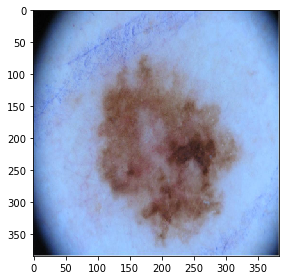

In [69]:
img = cv2.imread(TRAIN_IMG_PATH + data_csv["image"][2] + ".jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
io.imshow(img)

# print(sys.getsizeof(img))

In [70]:
def load_isic_training_data(image_folder, ground_truth_file):
    df_ground_truth = pd.read_csv(ground_truth_file)
    # Category names
    known_category_names = list(df_ground_truth.columns.values[1:9])
    unknown_category_name = df_ground_truth.columns.values[9]
    
    # Add path and category columns
    df_ground_truth['path'] = df_ground_truth.apply(lambda row : os.path.join(image_folder, row['image']+'.jpg'), axis=1)
    df_ground_truth['category'] = np.argmax(np.array(df_ground_truth.iloc[:,1:10]), axis=1)
    return df_ground_truth, known_category_names, unknown_category_name

def compute_class_dist(df,known_category_names):
    sample_count_train = df.shape[0]
    count_per_category_train = Counter(df['category'])
    for i, c in enumerate(known_category_names):
        print("'%s':\t%d\t(%.2f%%)" % (c, count_per_category_train[i], count_per_category_train[i]*100/sample_count_train))

    return


In [73]:
df_ground_truth, known_category_names, unknown_category_name = load_isic_training_data(
    TRAIN_IMG_PATH, DATA_PATH
)
df_ground_truth.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,path,category
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ISIC_2019_Training_Input/ISIC_2019_Training_In...,1
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ISIC_2019_Training_Input/ISIC_2019_Training_In...,1
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ISIC_2019_Training_Input/ISIC_2019_Training_In...,0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ISIC_2019_Training_Input/ISIC_2019_Training_In...,1
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ISIC_2019_Training_Input/ISIC_2019_Training_In...,0


In [41]:
df_ground_truth["kfold"] = -1
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
for f, (t_, v_) in enumerate(
    kf.split(X=df_ground_truth, y=df_ground_truth["category"])
):
    df_ground_truth.loc[v_, "kfold"] = f

In [42]:
df_fold1 = df_ground_truth[df_ground_truth["kfold"] == 1]
df_fold2 = df_ground_truth[df_ground_truth["kfold"] == 2]

print("FOLD 1 DISTRIBUTION \n")
compute_class_dist(df_fold1, known_category_names)
print("\n FOLD 2 DISTRIBUTION \n")
compute_class_dist(df_fold2, known_category_names)

FOLD 1 DISTRIBUTION 

'MEL':	905	(17.86%)
'NV':	2575	(50.83%)
'BCC':	664	(13.11%)
'AK':	173	(3.41%)
'BKL':	524	(10.34%)
'DF':	48	(0.95%)
'VASC':	51	(1.01%)
'SCC':	126	(2.49%)

 FOLD 2 DISTRIBUTION 

'MEL':	904	(17.84%)
'NV':	2575	(50.83%)
'BCC':	664	(13.11%)
'AK':	173	(3.41%)
'BKL':	525	(10.36%)
'DF':	48	(0.95%)
'VASC':	51	(1.01%)
'SCC':	126	(2.49%)


In [74]:
class ClassificationDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        image_paths,
        targets,
        resize,
        augmentations=None,
        backend="pil",
        channel_first=True,
    ):
        """
        :param image_paths: list of paths to images
        :param targets: numpy array
        :param resize: tuple or None
        :param augmentations: albumentations augmentations
        """
        super().__init__()
        self.image_paths = image_paths
        self.targets = targets
        self.augmentations = augmentations
        self.backend = backend

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, item):
        targets = self.targets[item]
        if self.backend == "pil":
            image = Image.open(self.image_paths[item]).convert("RGB")
            #             image = np.array(image)
            if self.augmentations is not None:
                image = self.augmentations(image)
        else:
            raise Exception("Backend not implemented")
        return image, targets

In [75]:
# Mean:[0.6237459654304592, 0.5201169854503829, 0.5039494477029685]
# STD:[0.24196317678786788, 0.2233599432947672, 0.23118716487089888]

_mean = np.array([0.6237459654304592, 0.5201169854503829, 0.5039494477029685])
_std = np.array([0.24196317678786788, 0.2233599432947672, 0.23118716487089888])

def get_transforms(image_size, rgb_mean, rgb_std):

#     transforms_train = A.Compose([
#         A.Resize(image_size, image_size),
#         A.Normalize(rgb_mean, rgb_std, max_pixel_value=255.0, always_apply=True),
#         A.Transpose(p=0.5),
#         A.VerticalFlip(p=0.5),
#         A.HorizontalFlip(p=0.5),
#         A.RandomBrightness(limit=0.2, p=0.75),
#         A.RandomContrast(limit=0.2, p=0.75),
#         A.OneOf([
#             A.MotionBlur(blur_limit=5),
#             A.MedianBlur(blur_limit=5),
#             A.GaussianBlur(blur_limit=5),
#             A.GaussNoise(var_limit=(5.0, 30.0)),
#         ], p=0.7),

#         A.OneOf([
#             A.OpticalDistortion(distort_limit=1.0),
#             A.GridDistortion(num_steps=5, distort_limit=1.),
#             A.ElasticTransform(alpha=3),
#         ], p=0.7),

# #         A.CLAHE(clip_limit=4.0, p=0.7),
#         A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
#         A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
#         A.Cutout(max_h_size=int(image_size * 0.375), max_w_size=int(image_size * 0.375), num_holes=1, p=0.7),
#         A.pytorch.ToTensorV2()
#     ])

#     transforms_val = A.Compose([
#         A.Resize(image_size, image_size),
#         A.Normalize(rgb_mean, rgb_std, max_pixel_value=255.0, always_apply=True),
#         A.pytorch.ToTensorV2()
#     ])

    # create image augmentations
    transforms_train = transforms.Compose(
        [
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.RandomHorizontalFlip(p=0.3),
            transforms.RandomVerticalFlip(p=0.3),
            transforms.RandomResizedCrop(IMG_SIZE),
            transforms.ToTensor(),
            transforms.Normalize(rgb_mean, rgb_std),
        ]
    )

    transforms_valid = transforms.Compose(
        [
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(rgb_mean, rgb_std),
        ]
    )

    return transforms_train, transforms_valid

def get_train_val(fold):
    df_train = df_ground_truth[df_ground_truth.kfold != fold]
    df_valid = df_ground_truth[df_ground_truth.kfold == fold]
    
    train_images = df_train['path'].to_list()
    train_targets = df_train['category'].to_numpy()
    
    valid_images = df_valid['path'].to_list()
    valid_targets = df_valid['category'].to_numpy()
    
    train_aug, valid_aug = get_transforms(IMG_SIZE, _mean, _std)

    train_dataset = ClassificationDataset(
        image_paths=train_images,
        targets=train_targets,
        resize=[IMG_SIZE,IMG_SIZE],
        augmentations=train_aug,
    )
    
    valid_dataset = ClassificationDataset(
        image_paths=valid_images,
        targets=valid_targets,
        resize=[IMG_SIZE,IMG_SIZE],
        augmentations=valid_aug,
    )
    
    return train_dataset, valid_dataset

def get_whole_dataset():

    images = df_ground_truth['path'].to_list()
    targets = df_ground_truth['category'].to_numpy()
    
    _,valid_aug = get_transforms(IMG_SIZE, _mean, _std)

    dataset = ClassificationDataset(
        image_paths=images,
        targets=targets,
        resize=[IMG_SIZE,IMG_SIZE],
        augmentations=valid_aug,
    )

    
    return dataset


In [76]:
class Model(nn.Module):
    def __init__(self, timm_model_name, n_classes=8, pretrained=False):

        super(Model, self).__init__()
        self.num_classes = n_classes

        self.model = timm.create_model(
            timm_model_name,
#             "mobilevitv2_200_384_in22ft1k",
            pretrained=pretrained,
            num_classes=self.num_classes,
        )

        # self.model.head = nn.Linear(self.model.head., n_classes)

    def forward(self, x):
        x = self.model(x)
        return x

    def train_one_epoch(self, train_loader, criterion, optimizer, device):
        # keep track of training loss
        epoch_loss = 0.0
        epoch_w_f1 = 0.0

        ###################
        # train the model #
        ###################
        self.model.train()
        for i, (data, target) in enumerate(train_loader):
            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()
            elif device.type == "xla":
                data = data.to(device, dtype=torch.float32)
                target = target.to(device, dtype=torch.int64)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = self.forward(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # Calculate Weighted F1
            w_f1 = f1_score(
                output, target, num_classes=self.num_classes, average="weighted"
            )
            # torchmetrics.functional.f1(output,target,num_classes=len(known_category_names),average='weighted')
            # update training loss and accuracy
            epoch_loss += loss
            epoch_w_f1 += w_f1

            # perform a single optimization step (parameter update)
            if device.type == "xla":
                xm.optimizer_step(optimizer)
                if i % 20 == 0:
                    xm.master_print(f"\tBATCH {i+1}/{len(train_loader)} - LOSS: {loss}")

            else:
                optimizer.step()
                if i % 20 == 0:
                    print(f"\tBATCH {i+1}/{len(train_loader)} - LOSS: {loss}")

        return epoch_loss / len(train_loader), epoch_w_f1 / len(train_loader)

    def validate_one_epoch(self, valid_loader, criterion, device):
        # keep track of validation loss
        valid_loss = 0.0
        valid_w_f1 = 0.0

        ######################
        # validate the model #
        ######################
        self.model.eval()
        for data, target in valid_loader:
            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()
            elif device.type == "xla":
                data = data.to(device, dtype=torch.float32)
                target = target.to(device, dtype=torch.int64)

            with torch.no_grad():
                # forward pass: compute predicted outputs by passing inputs to the model
                output = self.model(data)
                # calculate the batch loss
                loss = criterion(output, target)
                # Calculate Weighted F1
                w_f1 = f1_score(
                    output, target, num_classes=self.num_classes, average="weighted"
                )
                # update average validation loss and accuracy
                valid_loss += loss
                valid_w_f1 += w_f1

        return valid_loss / len(valid_loader), valid_w_f1 / len(valid_loader)

In [77]:
def fit_gpu(
    model, epochs, device, criterion, optimizer, train_loader, valid_loader=None
):

    valid_loss_min = np.Inf  # track change in validation loss

    # keeping track of losses as it happen
    train_losses = []
    valid_losses = []
    train_f1s = []
    valid_f1s = []

    for epoch in range(1, epochs + 1):
        gc.collect()
        #         para_train_loader = pl.ParallelLoader(train_loader, [device])

        print(f"{'='*50}")
        print(f"EPOCH {epoch} - TRAINING...")
        train_loss, train_w_f1 = model.train_one_epoch(
            train_loader, criterion, optimizer, device
        )
        print(
            f"\n\t[TRAIN] EPOCH {epoch} - LOSS: {train_loss}, WEIGHTED F1: {train_w_f1}\n"
        )
        train_losses.append(train_loss)
        train_f1s.append(train_w_f1)
        gc.collect()

        if valid_loader is not None:
            gc.collect()
            #         para_valid_loader = pl.ParallelLoader(valid_loader, [device])
            print(f"EPOCH {epoch} - VALIDATING...")
            valid_loss, valid_w_f1 = model.validate_one_epoch(
                valid_loader, criterion, device
            )
            print(f"\t[VALID] LOSS: {valid_loss},  WEIGHTED F1: {valid_w_f1}\n")
            valid_losses.append(valid_loss)
            valid_f1s.append(valid_w_f1)
            gc.collect()

            # save model if validation loss has decreased
            if valid_loss <= valid_loss_min and epoch != 1:
                print(
                    "Validation loss decreased ({:.4f} --> {:.4f}).  Saving model ...".format(
                        valid_loss_min, valid_loss
                    )
                )
            torch.save(
                model.state_dict(),
                f'efficientnet_b3{datetime.now().strftime("%Y%m%d-%H%M")}.pth',
            )
            valid_loss_min = valid_loss

    return {
        "train_loss": train_losses,
        "valid_losses": valid_losses,
        "train_w_f1": train_f1s,
        "valid_w_f1": valid_f1s,
    }

In [145]:
BATCH_SIZE = 64
LR = 2e-05
GAMMA = 0.7
N_EPOCHS = 20

In [48]:
# model = MobileVitV2(n_classes=len(known_category_names), pretrained=True)
model = Model('efficientnet_b3',pretrained=True)
# model.to(torch.device("cuda"))
# summary(model, (3, IMG_SIZE, IMG_SIZE))

In [49]:
def _run(fold):
    train_dataset, valid_dataset = get_train_val(fold)

    #     train_sampler = torch.utils.data.Sampler(
    #         train_dataset,
    #         num_replicas=torch.cuda.device_count(),
    #         rank=0,
    #         shuffle=True,
    #     )

    #     valid_sampler = torch.utils.data.Sampler(
    #         valid_dataset,
    #         num_replicas=torch.cuda.device_count(),
    #         rank=0,
    #         shuffle=False,
    #     )

    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        #         sampler=train_sampler,
        drop_last=True,
        #         num_workers=torch.cuda.device_count(),
    )

    valid_loader = torch.utils.data.DataLoader(
        dataset=valid_dataset,
        batch_size=BATCH_SIZE,
        #         sampler=valid_sampler,
        drop_last=True,
        #         num_workers=torch.cuda.device_count(),
    )

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #     device = xm.xla_device()
    model.to(device)

    lr = LR * torch.cuda.device_count()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    print(f"INITIALIZING TRAINING ON {torch.cuda.device_count()} GPU CORES")
    start_time = datetime.now()
    print(f"Start Time: {start_time}")

    logs = fit_gpu(
        model=model,
        epochs=N_EPOCHS,
        device=device,
        criterion=criterion,
        optimizer=optimizer,
        train_loader=train_loader,
        valid_loader=valid_loader,
    )

    print(f"Execution time: {datetime.now() - start_time}")

    print("Saving Model")
    torch.save(
        model.state_dict(),
        f'model_efficientnet_b3_{datetime.now().strftime("%Y%m%d-%H%M")}.pth',
    )

In [50]:
# for i in range(5):
#     start_time = time.time()
#     _run(i)

In [118]:
dataset = get_whole_dataset()
    
data_loader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    #         sampler=valid_sampler,
    drop_last=True,
    #         num_workers=torch.cuda.device_count(),
)

In [129]:
x,y = iter(data_loader).next()
x, y = x.cuda(), y.cuda()

In [128]:
model.load_state_dict(torch.load('efficientnet_b320221021-2117.pth'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
model.to(device)
pass

tensor(0.8232, device='cuda:0')

In [146]:
def evaluate_model(model_name):
    model.load_state_dict(torch.load(model_name))
    dataset = get_whole_dataset()
    
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=BATCH_SIZE,
        #         sampler=valid_sampler,
        drop_last=True,
        #         num_workers=torch.cuda.device_count(),
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = nn.CrossEntropyLoss()
    model.to(device)
    
    valid_loss, valid_w_f1 = model.validate_one_epoch(
                data_loader, criterion, device
            )
    return valid_loss, valid_w_f1

    

In [147]:
evaluate_model("efficientnet_b320221021-2117.pth")

(tensor(41.0336, device='cuda:0'), tensor(0.7940, device='cuda:0'))

In [150]:
evaluate_model("efficientnet_b320221021-2041.pth")

(tensor(37.5272, device='cuda:0'), tensor(0.7901, device='cuda:0'))

In [151]:
evaluate_model("efficientnet_b320221021-2005.pth")

(tensor(23.0999, device='cuda:0'), tensor(0.7877, device='cuda:0'))